<a href="https://colab.research.google.com/github/juansebastiangit/Inteigencia_artificial/blob/main/tareas/PCA_autoencoder_con_clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Implementacion modelo PCA en redes neuronales


In [ ]:
import tensorflow as tf
import plotly.express as px
import keras as keras
from tensorflow.keras import layers, losses, Model
from tensorflow.keras.datasets import mnist
import numpy as np

# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
scale = 0.4
x_train = x_train.astype('float32') / 255. + np.random.normal(scale=scale,size=x_train.shape)
x_test = x_test.astype('float32') / 255. + np.random.normal(scale=scale,size=x_test.shape)

# create training, validation, and testing sets
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]
x_train = x_train[..., tf.newaxis]
x_val = x_val[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1) (50000,) (10000,) (10000,)


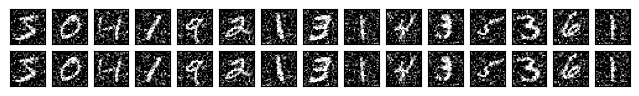

In [ ]:
import matplotlib.pyplot as plt

#plot original images vs reconstructed images
def plot_mnist_autoencoder(x,xpred,cmap='gray',vmin=0,vmax=1):
  fig,ax = plt.subplots(2,x.shape[0],figsize=(8,1))
  for i,class_ in enumerate(range(x.shape[0])):
        ax[0,i].imshow(x[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])

        ax[1,i].imshow(xpred[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
  plt.show()
  return

plot_mnist_autoencoder(x_train[:15],x_train[:15])


In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#plot images on latent space
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.axis('off')
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()
    plt.show()

In [ ]:
class DenseTransposeLayer(layers.Layer):
    def __init__(self, units, factor_o=0.1,activation=None, **kwargs):
        super(DenseTransposeLayer, self).__init__(**kwargs)
        self.units = units
        self.factor_o = factor_o
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape, self.units),
            initializer="random_normal",
            trainable=True,regularizer=tf.keras.regularizers.OrthogonalRegularizer(factor=self.factor_o),
            constraint=tf.keras.constraints.max_norm(1.)
        )
        #self.b1 = self.add_weight(
        #    shape=(self.units,), initializer="zeros", trainable=True)
        #self.b2 = self.add_weight(
        #    shape=(input_shape[-1],), initializer="zeros", trainable=True)

        super(DenseTransposeLayer, self).build(input_shape)

    def call(self, inputs):
        x = tf.linalg.matmul(inputs, self.w) #+ self.b1
        if self.activation is not None:
            x = self.activation(x)
        y = tf.linalg.matmul(x, tf.transpose(self.w)) #+ self.b2
        return x,y

In [ ]:
#Autoencoder de muestra compartido en github

# Orthogonal Autoencoder with linear activation : PCA as keras-based NN

#custom autoencoder
class PCAutoencoder(Model):
    def __init__(self, encoding_dim,factor_o=0.1):
        super(PCAutoencoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.factor_o=factor_o
        # Encoder layers
        self.encoder_input_layer = layers.Flatten()

        # Decoder layers will be initialized in build()
        self.encoder_decoder_transpose = DenseTransposeLayer(self.encoding_dim, factor_o=self.factor_o,activation='linear')
        self.decoder_output_layer = None

    def build(self, input_shape):
        # Now that we have the input shape, initialize decoder layers
        self.encoder_decoder_transpose.build(input_shape[1]*input_shape[2])
        self.decoder_output_layer = layers.Reshape(input_shape[1:])
        super().build(input_shape)


    def call(self, inputs):
        x = self.encoder_input_layer(inputs)
        x = self.encoder_decoder_transpose(x)
        decoded = self.decoder_output_layer(x)
        return decoded

In [ ]:
#Autoencoder con las capas de clasificación

class PCAutoencoderWithClassification(Model):
    def __init__(self, encoding_dim, num_classes, factor_o=0.1):
        super(PCAutoencoderWithClassification, self).__init__()
        self.encoding_dim = encoding_dim
        self.factor_o = factor_o
        self.num_classes = num_classes

        # Encoder layers
        self.encoder_input_layer = layers.Flatten()

        # Decoder layers
        self.encoder_decoder_transpose = DenseTransposeLayer(self.encoding_dim, factor_o=self.factor_o, activation='linear')
        self.decoder_output_layer = None

        # Classification layers
        self.classification_dense1 = layers.Dense(100, activation='selu',name="Class1")
        self.classification_dense2 = layers.Dense(50, activation='selu',name="Class2")
        self.classification_dense3 = layers.Dense(self.num_classes, activation='softmax',name="ClassOutput")

    def build(self, input_shape):
        # Initialize decoder layers
        self.encoder_decoder_transpose.build(input_shape[1] * input_shape[2])
        self.decoder_output_layer = layers.Reshape(input_shape[1:])

        # Build classification layers
        self.classification_dense1.build((None, 64))
        self.classification_dense2.build((None, 100))
        self.classification_dense3.build((None, 50))

        super().build(input_shape)

    def call(self, inputs):
        x = self.encoder_input_layer(inputs)
        encoded,y = self.encoder_decoder_transpose(x)
        decoded = self.decoder_output_layer(y)

        # Classification
        x = self.classification_dense1(encoded)
        y = self.classification_dense2(x)
        classification_output = self.classification_dense3(y)

        return decoded, classification_output

In [ ]:
# Instantiate the autoencoder
encoding_dim = 64
input_shape = (None, 28, 28, 1)
factor_o = 0.1
num_classes=10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
pcautoencoder = PCAutoencoderWithClassification(encoding_dim,num_classes,factor_o=factor_o)
pcautoencoder.build(input_shape)
pcautoencoder.compile(optimizer='adam', loss=['mse',"sparse_categorical_crossentropy"],loss_weights=[0.5,0.5])
pcautoencoder.summary()


Model: "pc_autoencoder_with_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_transpose_layer (Den  multiple                  50176     
 seTransposeLayer)                                               
                                                                 
 Class1 (Dense)              multiple                  6500      
                                                                 
 Class2 (Dense)              multiple                  5050      
                                                                 
 ClassOutput (Dense)         multiple                  510       
                                                                 
 reshape (Reshape)           multiple                  0         
                                

In [ ]:
history=pcautoencoder.fit(x_train,[x_train,y_train],64,20, validation_data=(x_val,[x_val,y_val]))

Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 0.3895 - output_1_loss: 0.2187 - output_2_loss: 0.5399 - val_loss: 0.2967 - val_output_1_loss: 0.2073 - val_output_2_loss: 0.3660
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 0.2775 - output_1_loss: 0.2054 - output_2_loss: 0.3294 - val_loss: 0.2562 - val_output_1_loss: 0.2042 - val_output_2_loss: 0.2881
Epoch 3/20
782/782 [==============================] - 5s 7ms/step - loss: 0.2387 - output_1_loss: 0.2018 - output_2_loss: 0.2554 - val_loss: 0.2330 - val_output_1_loss: 0.2005 - val_output_2_loss: 0.2453
Epoch 4/20
782/782 [==============================] - 6s 7ms/step - loss: 0.2139 - output_1_loss: 0.1990 - output_2_loss: 0.2085 - val_loss: 0.2248 - val_output_1_loss: 0.1990 - val_output_2_loss: 0.2302
Epoch 5/20
782/782 [==============================] - 5s 7ms/step - loss: 0.1984 - output_1_loss: 0.1973 - output_2_loss: 0.1792 - val_loss: 0.2205 - val_output_1_loss: 0.1976 - val_o

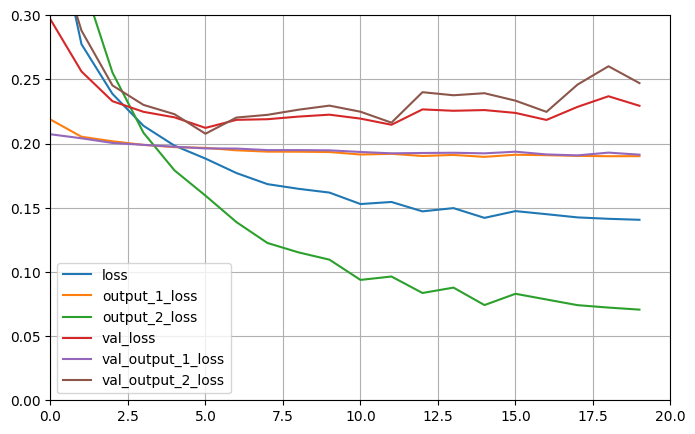

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.xlim(0,20)
plt.ylim(0,0.3)
plt.show()

In [ ]:
pcautoencoder.evaluate(x_test,[x_test,y_test])


313/313 [==============================] - 1s 4ms/step - loss: 0.2406 - output_1_loss: 0.1914 - output_2_loss: 0.2694


[0.24061627686023712, 0.1914452761411667, 0.2693587839603424]

313/313 [==============================] - 1s 2ms/step


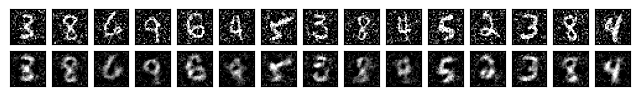

In [ ]:
a=pcautoencoder.predict(x_val)
plot_mnist_autoencoder(x_val[:15],a[0][:15])

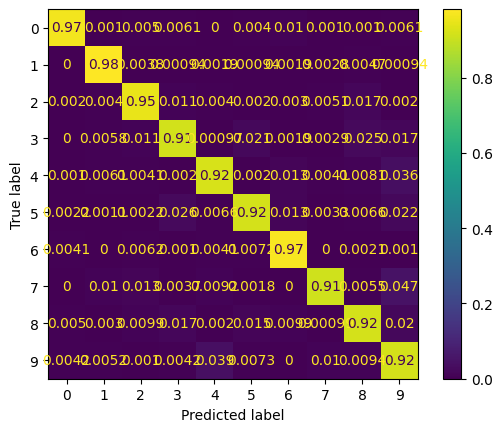

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm=confusion_matrix(y_val,a[1].argmax(axis=1),normalize="true")
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Epoch 1, Loss: 0.12885279953479767, Test Loss: 0.23216675221920013
Epoch 2, Loss: 0.1166028380393982, Test Loss: 0.17937687039375305
Epoch 3, Loss: 0.11460189521312714, Test Loss: 0.18464788794517517
Epoch 4, Loss: 0.11802363395690918, Test Loss: 0.3177098035812378
Epoch 5, Loss: 0.12218799442052841, Test Loss: 0.19771607220172882


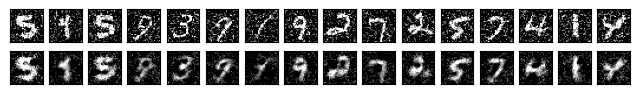

Epoch 6, Loss: 0.12072572112083435, Test Loss: 0.19873586297035217
Epoch 7, Loss: 0.11235319823026657, Test Loss: 0.29803216457366943
Epoch 8, Loss: 0.11787208914756775, Test Loss: 0.4349822998046875
Epoch 9, Loss: 0.1188211590051651, Test Loss: 0.20721961557865143
Epoch 10, Loss: 0.11478585749864578, Test Loss: 0.23840102553367615


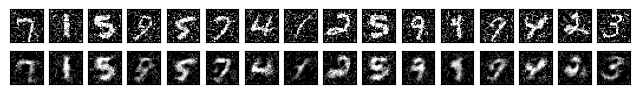

Epoch 11, Loss: 0.1159249022603035, Test Loss: 0.36363086104393005
Epoch 12, Loss: 0.11744232475757599, Test Loss: 0.3971427083015442
Epoch 13, Loss: 0.11687660962343216, Test Loss: 0.3434350788593292
Epoch 14, Loss: 0.11465681344270706, Test Loss: 0.2615787982940674
Epoch 15, Loss: 0.11368236690759659, Test Loss: 0.2828991413116455


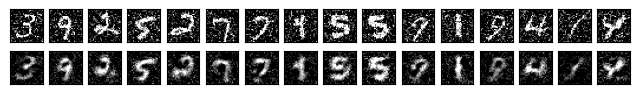

Epoch 16, Loss: 0.11569361388683319, Test Loss: 0.2166977971792221
Epoch 17, Loss: 0.11825748533010483, Test Loss: 0.27008795738220215
Epoch 18, Loss: 0.11336029320955276, Test Loss: 0.678420901298523
Epoch 19, Loss: 0.11392740905284882, Test Loss: 0.3023577928543091
Epoch 20, Loss: 0.11465086042881012, Test Loss: 0.3864527642726898


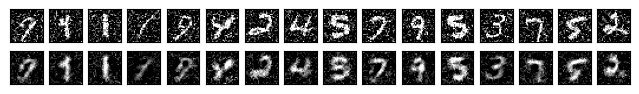

In [ ]:
#pca Autoencoder Training
# Define the loss object and the optimizer
tf.keras.backend.clear_session()
#primero tratamos el fit antes de correr esta parte, y hay que organizar el loss_object para que tenga todo lo de combinar 2 loss
#CREAMOS UN CUSTOM LOSS OBJECT COMO UNA CLASE
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, mse_weight, ce_weight):
        super().__init__()
        self.mse_weight = mse_weight
        self.ce_weight = ce_weight
        self.mse_loss_fn = tf.keras.losses.MeanSquaredError()
        self.ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    def call(self, y_true,y_pred):
        mse_loss = self.mse_loss_fn(y_true[0], y_pred[0])
        ce_loss = self.ce_loss_fn(y_true[1], y_pred[1])
        total_loss = (self.mse_weight * mse_loss) + (self.ce_weight * ce_loss)
        return total_loss

# Example usage:
mse_weight = 0.4
ce_weight = 1-mse_weight
loss_object = CustomLoss(mse_weight, ce_weight)
#loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Define measures to track loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='val_loss')
@tf.function
def train_step(images,labels):
    with tf.GradientTape() as tape:
        reconstructed = pcautoencoder(images, training=True)
        train_gides=[images,labels]
        loss = loss_object(train_gides,reconstructed)
        gradients = tape.gradient(loss, pcautoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pcautoencoder.trainable_variables))
    train_loss(loss)

@tf.function
def test_step(images,labels):
    reconstructed = pcautoencoder(images, training=False)
    test_gides=[images,labels]
    t_loss = loss_object(test_gides, reconstructed)
    test_loss(t_loss)

# Training loop
epochs = 20
batch_size = 64
# Prepare the dataset for training
#train_dataset= tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(x_val).shuffle(buffer_size=128).batch(batch_size)

for epoch in range(epochs):
    # Reset the metrics at the start of each epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x_batch,y_batch in tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1024).batch(batch_size):
        train_step(x_batch,y_batch)

    for x_val,y_val in tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(buffer_size=1024).batch(batch_size):
        test_step(x_val,y_val)

    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Test Loss: {test_loss.result()}')
    if (epoch+1)%5 == 0:
      val_reconstructed,val_classification = pcautoencoder(x_val, training=False)
      #print(val_reconstructed.shape)
      plot_mnist_autoencoder(x_val,val_reconstructed)


313/313 [==============================] - 1s 2ms/step


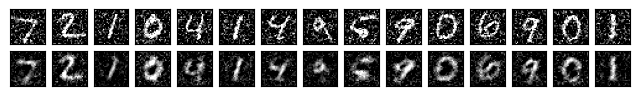

In [ ]:
prediction=pcautoencoder.predict(x_test)
plot_mnist_autoencoder(x_test[:15],prediction[0][:15])
latent_space = tf.keras.Model(inputs=pcautoencoder.inputs,outputs=pcautoencoder.get_layer('h2').output) #se accede a capas por nombre
tf.keras.utils.plot_model(model_B) # modelo ya esta ajustado!